In [1]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
train_data=shuffle(pd.read_csv('train.csv'))
val_data=shuffle(pd.read_csv('val.csv'))
unlabeled_data=shuffle(pd.read_csv('unlabeled_v2.csv'))

In [3]:
train_data=train_data[:5000]
val_data=val_data[:10000]

#### scorer

In [4]:
f1 = make_scorer(f1_score , average='macro')

# Data exploring

<BarContainer object of 3 artists>

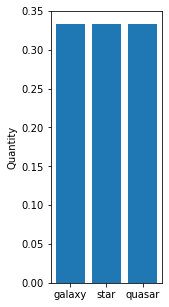

In [5]:
names = ['galaxy', 'star', 'quasar']
counts = train_data['class'].value_counts([0,1,2])
plt.figure(figsize=(2, 5))
plt.ylabel('Quantity')
plt.bar(names, counts)

#### train_data balanced

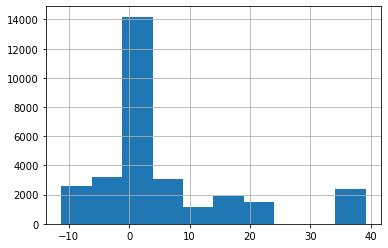

In [6]:
h = train_data['dec'].hist()
fig = h.get_figure()

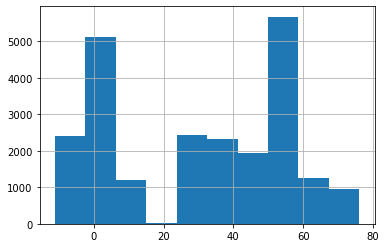

In [7]:
h = val_data['dec'].hist()
fig = h.get_figure()

#### как видим огромная часть val_data.dec лежит в диапазоне  от 30 до 70; в train_data почти все значения dec лежат возле 0

# Functions

In [5]:
def preprocessing(data: pd.DataFrame):
    f = 'class' in data
    if f:
        labels=data['class']
        data=data.drop(columns='class')
    data=data.apply(pd.to_numeric)
    data=data.drop(columns=['objid', 'ra', 'dec', 'clean'])
    #data=data.drop(columns=['objid'])
    if f:
        return (data, labels)
    else:
        return data

def null_processing(data: pd.DataFrame)  ->  pd.DataFrame:
    data=data.replace({'na':np.NaN})
    data.fillna(data.median(), inplace=True)
    return data

def null_knn(data: pd.DataFrame)  ->  pd.DataFrame:
    data=data.replace({'na':np.NaN})
    imputer = KNNImputer(n_neighbors=30,metric='nan_euclidean')
    data = pd.DataFrame(imputer.fit_transform(data),columns = data.columns)
    return data

def predict_info(predict):
    a0=0
    a1=0
    a2=0
    for j in predict:
        if j==0:
            a0+=1
        elif j==1:
            a1+=1
        elif j==2:
            a2+=1
    print(a0,a1,a2)

In [6]:
def Clustering1(data: pd.DataFrame, train_data: pd.DataFrame)->pd.DataFrame:
    for band in ['u','g','r','i','z']:
        columns = []
        for i in range(6):
            s=band+'_'+str(i)
            columns.append(s)
        cluster_name='cluster_'+band
        model = KMeans(n_clusters = 10, random_state = 42)
        model.fit(train_data[columns])
        data[cluster_name]=model.predict(data[columns])
    return data

def Clustering2(data: pd.DataFrame, train_data: pd.DataFrame)->pd.DataFrame:
    for i in range(6):
        columns = []
        for band in ['u','g','r','i','z']:
            s=band+'_'+str(i)
            columns.append(s)
        cluster_name='cluster_'+str(i)
        model = KMeans(n_clusters = 10, random_state = 42)
        model.fit(train_data[columns])
        data[cluster_name]=model.predict(data[columns])
    return data

# Null processing

In [7]:
#unlabeled_data=null_processing(unlabeled_data)
#train_data=null_processing(train_data)
#val_data=null_processing(val_data)

unlabeled_data=null_knn(unlabeled_data)
train_data=null_knn(train_data)
val_data=null_knn(val_data)

In [8]:
train_data.head()

,objid,ra,dec,u_0,g_0,r_0,i_0,z_0,clean,rowc,...,g_5,r_5,i_5,z_5,u_6,g_6,r_6,i_6,z_6,class
0,30056.0,58.693860,-4.705502,17.906760,21.258917,15.081190,14.56337,14.16487,1.0,80.87382,...,-0.113362,-0.104191,0.013575,-0.086615,3.0,3.0,7.0,3.0,5.0,1.0
1,88988.0,156.824490,0.283384,17.574530,16.385950,16.489780,16.61654,16.73915,1.0,469.16510,...,0.029043,-0.014913,-0.004570,0.026165,6.0,8.0,6.0,4.0,0.0,1.0
2,38763.0,158.577400,8.119606,21.701020,19.969390,22.168060,24.86762,18.85969,0.0,624.67590,...,-0.012575,-0.106629,0.344812,0.821800,3.0,5.0,1.0,1.0,5.0,0.0
3,50983.0,22.547143,38.914431,23.205320,23.693740,19.647354,22.09022,23.62659,1.0,504.38990,...,0.062271,-0.068304,0.188028,-2.269322,3.0,8.0,5.0,7.0,2.0,0.0
4,96748.0,157.409766,-0.728309,22.204771,20.575680,20.158960,20.01624,20.07253,1.0,442.46900,...,-0.014730,-0.002393,-0.041777,-0.085092,6.0,6.0,8.0,5.0,0.0,2.0


# Data preprocessing

In [9]:
train_data, train_labels = preprocessing(train_data)
val_data, val_labels = preprocessing(val_data)
unlabeled_data = preprocessing(unlabeled_data)

# Clustering

In [10]:
train_data=Clustering1(train_data, pd.concat([train_data, unlabeled_data]))
val_data=Clustering1(val_data, pd.concat([train_data, unlabeled_data]))
unlabeled_data = Clustering1(unlabeled_data, pd.concat([train_data, unlabeled_data]))
train_data=Clustering2(train_data, pd.concat([train_data, unlabeled_data]))
val_data=Clustering2(val_data, pd.concat([train_data, unlabeled_data]))
unlabeled_data = Clustering2(unlabeled_data, pd.concat([train_data, unlabeled_data]))

#train_data=Clustering1(train_data,unlabeled_data)
#val_data=Clustering1(val_data, unlabeled_data)
#unlabeled_data = Clustering1(unlabeled_data, unlabeled_data)
#train_data=Clustering2(train_data, unlabeled_data)
#val_data=Clustering2(val_data, unlabeled_data)
#unlabeled_data = Clustering2(unlabeled_data, unlabeled_data)

In [ ]:
train_data.tail()

# Models

## XGB

In [ ]:
    
params = { 
    'learning_rate': 0.025,
    'n_estimators': 1000,
    'max_depth': 6,
    'subsample': 0.75,
    'colsample_bytree': 0.5,
    'gamma': 1,
    'objective': 'multi:softmax'
}
mlflow.set_experiment('XGB')
with mlflow.start_run():
    model = XGBClassifier(**params, random_state=42)
    model.fit(train_data, train_labels, eval_metric='auc')
    score = f1_score(model.predict(val_data), val_labels, average='macro')
    print('f1: ', score)
    mlflow.log_param('params', params)
    mlflow.log_metric('f1_macro', score)
#0.8436

In [ ]:
cv_score = cross_validate(model, train_data, train_labels, cv=4, scoring=["f1_micro", "f1_macro", "f1_weighted", "accuracy"], n_jobs=-1)
cv_score

In [12]:
cv_score['test_f1_macro'].mean()
#0.857

0.8572360333430123

In [ ]:
a0=0
a1=0
a2=0
#print(len(train_data))
#print(len(model.predict
for i,j in enumerate(model.predict(val_data)):
    if j==0:
        a0+=1
    elif j==1:
        a1+=1
    elif j==2:
        a2+=1
print(a0,a1,a2)

In [33]:
f1_score(model.predict(val_data), val_labels, average='macro')

0.843634461423992

In [32]:
accuracy_score(model.predict(val_data), val_labels)

0.8719410277289675

In [34]:
cv_score = cross_validate(model, train_data, train_labels, cv=4, scoring='accuracy', n_jobs=-1)

In [39]:
cv_score['test_score'].mean()

0.8573666666666667

In [40]:
cv_score = cross_validate(model, train_data, train_labels, cv=10, scoring='accuracy', n_jobs=-1)

In [41]:
cv_score['test_score'].mean()

0.8591666666666666

#### gridsearch(XGB)

In [20]:
params = {
    'random_state': [42],
    'tree_method': ['hist'],
    'grow_policy': ['lossguide'],
    'n_estimators': [500,1000],
    'eta': [0.01,0.02,0.03],
    'max_depth': [2,3,4,5,6],
    'min_child_weight': [1],
    'max_bin': [120,240],
    'subsample': [0.5,0.8,0.95],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],

}

In [42]:
GridS.best_params_

{'eta': 0.02,
 'grow_policy': 'lossguide',
 'max_bin': 120,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 1000,
 'random_state': 42,
 'reg_lambda': 100.0,
 'subsample': 0.5,
 'tree_method': 'hist'}

## SVM

In [56]:
params = {'C': 0.1, 'coef0': 0.001, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
model = SVC(**params)
clf = make_pipeline(StandardScaler(), model)
#print('cv accuracy: ', cross_val_score(clf, train_data, train_labels, scoring='accuracy', cv = 10).mean())
clf.fit(train_data, train_labels)
predictions_SVM = clf.predict(val_data)
print('f1: ', f1_score(clf.predict(val_data), val_labels,average='macro'))

f1:  0.7707807340941862


#### gridsearch(SVM)

In [73]:
params = {
    'kernel' : ['rbf'],
    'C' : [0.1,0.5,1],
    'degree': [3,6,9],
    'coef0': [0.001,2],
    'gamma': ('auto', 'scale')
}

In [74]:
GSmodel=SVC()
GridS = GridSearchCV(GSmodel,params, cv=3,verbose=3, n_jobs=-1,scoring=f1)
GridS.fit(train_data, train_labels)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 41.0min finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1], 'coef0': [0.001, 2],
                         'degree': [3, 6, 9], 'gamma': ('auto', 'scale'),
                         'kernel': ['rbf']},
             scoring=make_scorer(f1_score, average=macro), verbose=3)

In [75]:
GridS.best_params_

{'C': 0.1, 'coef0': 0.001, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

In [60]:
predict_info(predictions_SVM)

16392 3648 3293


In [59]:
a0=0
a1=0
a2=0
for i,j in enumerate(clf.predict(val_data)):
    if j==0:
        a0+=1
    elif j==1:
        a1+=1
    elif j==2:
        a2+=1
print(a0,a1,a2)

16392 3648 3293


# RF

In [57]:
params = {"n_estimators": 10,
    "criterion": "gini",
    "min_samples_split": 10,
    "max_features": "auto",
    "bootstrap": True,
    "n_jobs": -1}
model = RandomForestClassifier(**params)
#print('cv accuracy: ', cross_val_score(model, train_data, train_labels, scoring='accuracy', cv = 10).mean())
model.fit(train_data, train_labels)
predictions_RF = model.predict(val_data)
print('f1: ', f1_score(model.predict(val_data), val_labels, average='macro'))

f1:  0.8021061899825855


In [15]:
rfc_knn_score = cross_validate(model, train_data, train_labels, cv=10, scoring=["f1_micro", "f1_macro", "f1_weighted"], n_jobs=-1)
rfc_knn_score

{'fit_time': array([1.91488361, 1.31097293, 1.95794892, 1.20080781, 1.25388598,
        1.48122883, 1.5463264 , 1.74062085, 1.16174889, 1.18077779]),
 'score_time': array([0.02002859, 0.57286286, 0.37256098, 0.64597249, 0.46469951,
        0.35553455, 0.30245638, 0.65098214, 0.02203393, 0.01702523]),
 'test_f1_micro': array([0.817     , 0.81066667, 0.81433333, 0.80366667, 0.85066667,
        0.831     , 0.836     , 0.849     , 0.83366667, 0.826     ]),
 'test_f1_macro': array([0.81616898, 0.81071378, 0.81400467, 0.8039977 , 0.85038787,
        0.82993452, 0.8351612 , 0.84830815, 0.83349679, 0.82619007]),
 'test_f1_weighted': array([0.81616898, 0.81071378, 0.81400467, 0.8039977 , 0.85038787,
        0.82993452, 0.8351612 , 0.84830815, 0.83349679, 0.82619007])}

In [ ]:
for k, v in rfc_knn_score.items():
    print(k, np.mean(v))

In [10]:
predict_info(predictions_RF)

15140 418 7775


# kNN

In [72]:
params={'n_neighbors': 13}
model = KNeighborsClassifier(**params)
clf = make_pipeline(StandardScaler(), model)
clf.fit(train_data, train_labels)

predictions_kNN = clf.predict(val_data)
print('f1: ', f1_score(clf.predict(val_data), val_labels, average='macro'))

f1:  0.7255196853171865


In [70]:
predict_info(predictions_kNN)

14569 3560 5204


In [15]:
model = KMeans(n_clusters = 10, random_state = 42)

# Catboost 

In [10]:
params ={
    'depth': 7,
    'iterations': 1000,
    'learning_rate': 0.05,
    'l2_leaf_reg': 0.01
    #'use_best_model': True
}
model = CatBoostClassifier(**params)
#print('cv accuracy: ', cross_val_score(model, train_data, train_labels, scoring='accuracy', cv = 10).mean())
model.fit(train_data, train_labels)
predictions_RF = model.predict(val_data)
print('f1: ', f1_score(model.predict(val_data), val_labels, average='macro'))
#0.826

0:	learn: 1.0488384	total: 117ms	remaining: 1m 56s
1:	learn: 1.0067540	total: 171ms	remaining: 1m 25s
2:	learn: 0.9686874	total: 230ms	remaining: 1m 16s
3:	learn: 0.9329943	total: 290ms	remaining: 1m 12s
4:	learn: 0.9014587	total: 350ms	remaining: 1m 9s
5:	learn: 0.8729478	total: 407ms	remaining: 1m 7s
6:	learn: 0.8466347	total: 464ms	remaining: 1m 5s
7:	learn: 0.8240926	total: 515ms	remaining: 1m 3s
8:	learn: 0.8024818	total: 574ms	remaining: 1m 3s
9:	learn: 0.7825750	total: 627ms	remaining: 1m 2s
10:	learn: 0.7638587	total: 680ms	remaining: 1m 1s
11:	learn: 0.7476058	total: 735ms	remaining: 1m
12:	learn: 0.7313722	total: 788ms	remaining: 59.8s
13:	learn: 0.7175167	total: 844ms	remaining: 59.4s
14:	learn: 0.7036144	total: 896ms	remaining: 58.8s
15:	learn: 0.6910687	total: 958ms	remaining: 58.9s
16:	learn: 0.6792352	total: 1.01s	remaining: 58.7s
17:	learn: 0.6684691	total: 1.07s	remaining: 58.4s
18:	learn: 0.6584435	total: 1.12s	remaining: 58s
19:	learn: 0.6488019	total: 1.18s	remainin

162:	learn: 0.4313813	total: 8.76s	remaining: 45s
163:	learn: 0.4311207	total: 8.8s	remaining: 44.9s
164:	learn: 0.4307455	total: 8.86s	remaining: 44.8s
165:	learn: 0.4303784	total: 8.9s	remaining: 44.7s
166:	learn: 0.4299273	total: 8.96s	remaining: 44.7s
167:	learn: 0.4293794	total: 9.01s	remaining: 44.6s
168:	learn: 0.4290499	total: 9.06s	remaining: 44.5s
169:	learn: 0.4286847	total: 9.11s	remaining: 44.5s
170:	learn: 0.4282285	total: 9.16s	remaining: 44.4s
171:	learn: 0.4275847	total: 9.21s	remaining: 44.4s
172:	learn: 0.4270256	total: 9.27s	remaining: 44.3s
173:	learn: 0.4266911	total: 9.31s	remaining: 44.2s
174:	learn: 0.4264054	total: 9.36s	remaining: 44.1s
175:	learn: 0.4257205	total: 9.41s	remaining: 44.1s
176:	learn: 0.4255112	total: 9.46s	remaining: 44s
177:	learn: 0.4249569	total: 9.52s	remaining: 44s
178:	learn: 0.4243606	total: 9.57s	remaining: 43.9s
179:	learn: 0.4240088	total: 9.63s	remaining: 43.9s
180:	learn: 0.4237150	total: 9.68s	remaining: 43.8s
181:	learn: 0.423590

322:	learn: 0.3792896	total: 18.9s	remaining: 39.7s
323:	learn: 0.3790901	total: 19s	remaining: 39.7s
324:	learn: 0.3787978	total: 19.1s	remaining: 39.6s
325:	learn: 0.3785810	total: 19.1s	remaining: 39.6s
326:	learn: 0.3782849	total: 19.2s	remaining: 39.5s
327:	learn: 0.3779312	total: 19.3s	remaining: 39.5s
328:	learn: 0.3776946	total: 19.3s	remaining: 39.4s
329:	learn: 0.3774855	total: 19.4s	remaining: 39.4s
330:	learn: 0.3773276	total: 19.5s	remaining: 39.4s
331:	learn: 0.3772063	total: 19.5s	remaining: 39.3s
332:	learn: 0.3769688	total: 19.6s	remaining: 39.2s
333:	learn: 0.3767217	total: 19.6s	remaining: 39.1s
334:	learn: 0.3765536	total: 19.7s	remaining: 39.1s
335:	learn: 0.3763510	total: 19.7s	remaining: 39s
336:	learn: 0.3759941	total: 19.8s	remaining: 38.9s
337:	learn: 0.3755308	total: 19.8s	remaining: 38.9s
338:	learn: 0.3753407	total: 19.9s	remaining: 38.8s
339:	learn: 0.3751192	total: 19.9s	remaining: 38.7s
340:	learn: 0.3748672	total: 20s	remaining: 38.6s
341:	learn: 0.3744

483:	learn: 0.3454443	total: 29s	remaining: 30.9s
484:	learn: 0.3452535	total: 29.1s	remaining: 30.9s
485:	learn: 0.3449765	total: 29.1s	remaining: 30.8s
486:	learn: 0.3448095	total: 29.2s	remaining: 30.8s
487:	learn: 0.3445251	total: 29.3s	remaining: 30.7s
488:	learn: 0.3443240	total: 29.3s	remaining: 30.6s
489:	learn: 0.3442245	total: 29.4s	remaining: 30.6s
490:	learn: 0.3440458	total: 29.4s	remaining: 30.5s
491:	learn: 0.3438041	total: 29.5s	remaining: 30.5s
492:	learn: 0.3437089	total: 29.6s	remaining: 30.4s
493:	learn: 0.3434594	total: 29.6s	remaining: 30.3s
494:	learn: 0.3433162	total: 29.7s	remaining: 30.3s
495:	learn: 0.3430085	total: 29.7s	remaining: 30.2s
496:	learn: 0.3427661	total: 29.8s	remaining: 30.2s
497:	learn: 0.3425202	total: 29.9s	remaining: 30.1s
498:	learn: 0.3422808	total: 29.9s	remaining: 30.1s
499:	learn: 0.3420236	total: 30s	remaining: 30s
500:	learn: 0.3417944	total: 30.1s	remaining: 29.9s
501:	learn: 0.3416004	total: 30.1s	remaining: 29.9s
502:	learn: 0.3413

643:	learn: 0.3175778	total: 38.7s	remaining: 21.4s
644:	learn: 0.3173622	total: 38.7s	remaining: 21.3s
645:	learn: 0.3172099	total: 38.8s	remaining: 21.3s
646:	learn: 0.3171239	total: 38.8s	remaining: 21.2s
647:	learn: 0.3169990	total: 38.9s	remaining: 21.1s
648:	learn: 0.3168990	total: 38.9s	remaining: 21.1s
649:	learn: 0.3167493	total: 39s	remaining: 21s
650:	learn: 0.3166262	total: 39.1s	remaining: 20.9s
651:	learn: 0.3163514	total: 39.1s	remaining: 20.9s
652:	learn: 0.3161628	total: 39.2s	remaining: 20.8s
653:	learn: 0.3160372	total: 39.3s	remaining: 20.8s
654:	learn: 0.3159744	total: 39.3s	remaining: 20.7s
655:	learn: 0.3158226	total: 39.4s	remaining: 20.6s
656:	learn: 0.3156226	total: 39.4s	remaining: 20.6s
657:	learn: 0.3153955	total: 39.5s	remaining: 20.5s
658:	learn: 0.3152458	total: 39.6s	remaining: 20.5s
659:	learn: 0.3151080	total: 39.6s	remaining: 20.4s
660:	learn: 0.3148996	total: 39.7s	remaining: 20.3s
661:	learn: 0.3147103	total: 39.7s	remaining: 20.3s
662:	learn: 0.31

805:	learn: 0.2934818	total: 48.8s	remaining: 11.7s
806:	learn: 0.2934114	total: 48.8s	remaining: 11.7s
807:	learn: 0.2933118	total: 48.9s	remaining: 11.6s
808:	learn: 0.2932085	total: 48.9s	remaining: 11.6s
809:	learn: 0.2929880	total: 49s	remaining: 11.5s
810:	learn: 0.2927579	total: 49.1s	remaining: 11.4s
811:	learn: 0.2926690	total: 49.1s	remaining: 11.4s
812:	learn: 0.2925820	total: 49.2s	remaining: 11.3s
813:	learn: 0.2925001	total: 49.3s	remaining: 11.3s
814:	learn: 0.2924275	total: 49.3s	remaining: 11.2s
815:	learn: 0.2923296	total: 49.4s	remaining: 11.1s
816:	learn: 0.2922455	total: 49.4s	remaining: 11.1s
817:	learn: 0.2921033	total: 49.5s	remaining: 11s
818:	learn: 0.2919637	total: 49.6s	remaining: 11s
819:	learn: 0.2918739	total: 49.6s	remaining: 10.9s
820:	learn: 0.2918347	total: 49.7s	remaining: 10.8s
821:	learn: 0.2916593	total: 49.7s	remaining: 10.8s
822:	learn: 0.2914902	total: 49.8s	remaining: 10.7s
823:	learn: 0.2914254	total: 49.9s	remaining: 10.6s
824:	learn: 0.2913

965:	learn: 0.2732393	total: 59s	remaining: 2.08s
966:	learn: 0.2731417	total: 59s	remaining: 2.01s
967:	learn: 0.2731097	total: 59.1s	remaining: 1.95s
968:	learn: 0.2729932	total: 59.2s	remaining: 1.89s
969:	learn: 0.2728179	total: 59.2s	remaining: 1.83s
970:	learn: 0.2726408	total: 59.3s	remaining: 1.77s
971:	learn: 0.2726015	total: 59.4s	remaining: 1.71s
972:	learn: 0.2724664	total: 59.5s	remaining: 1.65s
973:	learn: 0.2722965	total: 59.5s	remaining: 1.59s
974:	learn: 0.2721148	total: 59.6s	remaining: 1.53s
975:	learn: 0.2720205	total: 59.6s	remaining: 1.47s
976:	learn: 0.2719021	total: 59.7s	remaining: 1.41s
977:	learn: 0.2717926	total: 59.8s	remaining: 1.34s
978:	learn: 0.2717440	total: 59.8s	remaining: 1.28s
979:	learn: 0.2716346	total: 59.9s	remaining: 1.22s
980:	learn: 0.2715528	total: 60s	remaining: 1.16s
981:	learn: 0.2714700	total: 1m	remaining: 1.1s
982:	learn: 0.2713239	total: 1m	remaining: 1.04s
983:	learn: 0.2712088	total: 1m	remaining: 978ms
984:	learn: 0.2710744	total:

In [11]:
cv_score = cross_validate(model, train_data, train_labels, cv=4, scoring=["f1_micro", "f1_macro", "f1_weighted", "accuracy"], n_jobs=-1)

In [15]:
cv_score

{'fit_time': array([220.22288537, 224.61137986, 224.77031326, 223.73598695]),
 'score_time': array([0.31636429, 0.10628986, 0.0441196 , 0.31034851]),
 'test_f1_micro': array([0.85506667, 0.85186667, 0.85586667, 0.85026667]),
 'test_f1_macro': array([0.85499771, 0.8516027 , 0.85539298, 0.85014932]),
 'test_f1_weighted': array([0.85499771, 0.8516027 , 0.85539298, 0.85014932]),
 'test_accuracy': array([0.85506667, 0.85186667, 0.85586667, 0.85026667])}

# Feature importance (XGB)

In [14]:
importance = model.feature_importances_.squeeze()
columns = train_data.columns

In [26]:
res = dict(zip(columns, importance)) 
res

{'u_0': 0.02138557,
 'g_0': 0.05248179,
 'r_0': 0.030337384,
 'i_0': 0.037116125,
 'z_0': 0.048464473,
 'clean': 0.089074925,
 'rowc': 0.0062960708,
 'colc': 0.006659851,
 'rowv': 0.008507476,
 'colv': 0.011087694,
 'u_1': 0.0064582834,
 'g_1': 0.006460147,
 'r_1': 0.006756885,
 'i_1': 0.0066626086,
 'z_1': 0.006719044,
 'u_2': 0.006486106,
 'g_2': 0.0070276856,
 'r_2': 0.0066424995,
 'i_2': 0.0069234343,
 'z_2': 0.007178054,
 'u_3': 0.018848326,
 'g_3': 0.042213615,
 'r_3': 0.020207489,
 'i_3': 0.026257364,
 'z_3': 0.013320675,
 'u_4': 0.00704155,
 'g_4': 0.0109742265,
 'r_4': 0.0103679625,
 'i_4': 0.008845788,
 'z_4': 0.0070118206,
 'u_5': 0.006950821,
 'g_5': 0.010223589,
 'r_5': 0.009369826,
 'i_5': 0.008519645,
 'z_5': 0.007679118,
 'u_6': 0.062195834,
 'g_6': 0.18332422,
 'r_6': 0.011770444,
 'i_6': 0.019977443,
 'z_6': 0.023038926,
 'cluster_u': 0.0065962914,
 'cluster_g': 0.0061175167,
 'cluster_r': 0.0059020794,
 'cluster_i': 0.006437174,
 'cluster_z': 0.005951612,
 'cluster_0

In [31]:
confusion_matrix(val_labels,model.predict(val_data))

array([[12248,   872,   213],
       [  672,  3653,   675],
       [  328,   228,  4444]], dtype=int64)